<a href="https://colab.research.google.com/github/Manuj99/pytorch/blob/main/pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.8.0+cu126'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10], len(X), len(y)

X = X.to(device)
y = y.to(device)


In [5]:
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [6]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [7]:
# Data Visulaization
def plot_parameters(train_data=X_train, test_data=X_test, train_labels=y_train, test_labels=y_test, predictions=None):
  plt.figure(figsize=(10,7))

  plt.scatter(train_data.cpu(), train_labels.cpu(), c='b', s=4, label="Training data")

  plt.scatter(test_data.cpu(), test_labels.cpu(), c='g', s=4, label="Test data")

  if predictions is not None:
    plt.scatter(test_data.cpu(), predictions.cpu(), c='r', s=6, label="Predicted data")

  plt.legend(prop={"size":14})


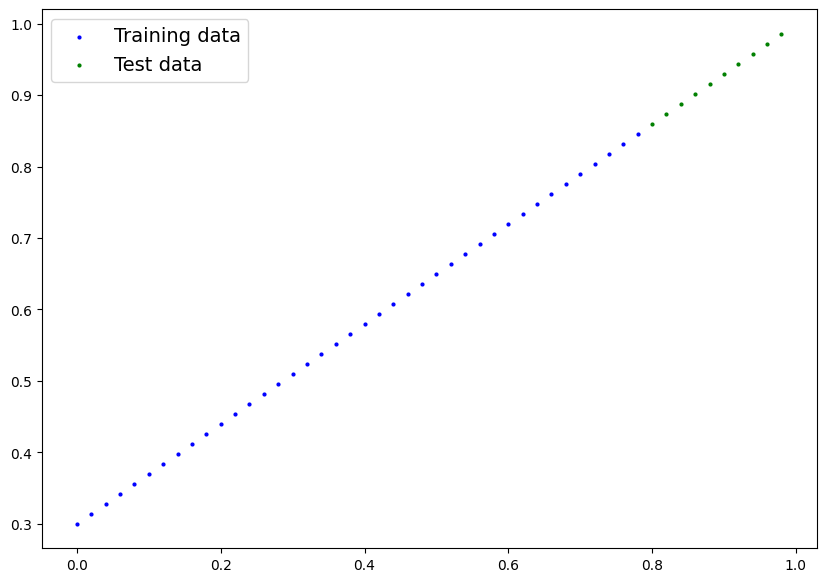

In [8]:
plot_parameters()

In [9]:
# Creating Model

class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.weight = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))
    self.bias = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float))

    self.weight.to(device)
    self.bias.to(device)

  def forward(self, x: torch.Tensor):
    return self.weight * x + self.bias

In [10]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()
model_0 = model_0.to(device)

In [11]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [12]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [13]:
# with torch.no_grad():
#   zero_preds = model_0(X_test)

# zero_preds

In [14]:
# non_infer_preds = model_0(X_test)
# non_infer_preds

In [15]:
with torch.inference_mode():
  initial_preds = model_0(X_test)

initial_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

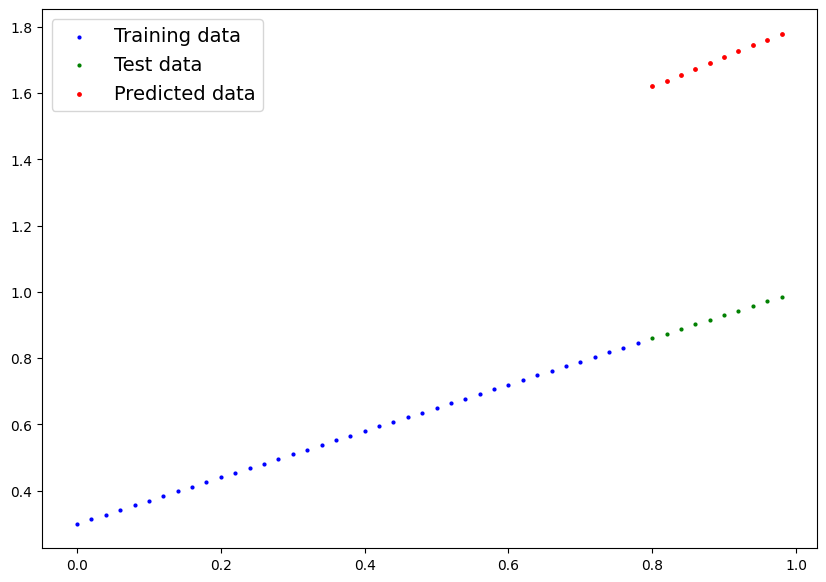

In [16]:
plot_parameters(predictions=initial_preds)

In [17]:
# setting up loss function
loss_func = nn.L1Loss()
loss_func

L1Loss()

In [18]:
# setting up optimizer(Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [19]:
epoch_counts = []
epoch_train_loss = []
epoch_test_loss = []

In [20]:
def test_model(test_data, test_labels, model_0, epoch, loss):
  model_0.eval()

  with torch.inference_mode():
    test_pred = model_0(test_data)

    test_loss = loss_func(test_pred, test_labels)

  if epoch % 10 == 0:
    epoch_counts.append(epoch)
    epoch_train_loss.append(loss)
    epoch_test_loss.append(test_loss)
    print(f"Iteration {epoch}: Test Loss = {test_loss}, Training_loss = {loss}")

In [21]:
def train_model(model_0, train_data, train_labels, epochs, test_data, test_labels):
  for epoch in range(epochs): # Run a train loop
    model_0.train() # Initialize model to train mode

    y_pred = model_0(train_data) # Make Initial Predictions

    loss = loss_func(y_pred, train_labels) # Calculate loss
    # print(f"Iteration {epoch} -> Loss: {loss}")

    optimizer.zero_grad() # Set optimizer to zero grad for fresh start otherwise all the predictions get accumulated at optimizer step

    loss.backward() # Back propagation

    optimizer.step() # Gradient Descent

    test_model(test_data, test_labels, model_0, epoch, loss)

    # print(model_0.state_dict())


In [22]:
train_model(model_0,X_train, y_train, 100, X_test, y_test)

Iteration 0: Test Loss = 0.7637526988983154, Training_loss = 0.6860889196395874
Iteration 10: Test Loss = 0.6290428042411804, Training_loss = 0.5708791017532349
Iteration 20: Test Loss = 0.4943329691886902, Training_loss = 0.45566922426223755
Iteration 30: Test Loss = 0.35962313413619995, Training_loss = 0.34045934677124023
Iteration 40: Test Loss = 0.2249133139848709, Training_loss = 0.2252494841814041
Iteration 50: Test Loss = 0.09020347893238068, Training_loss = 0.1100396141409874
Iteration 60: Test Loss = 0.020998019725084305, Training_loss = 0.009724985808134079
Iteration 70: Test Loss = 0.014099234715104103, Training_loss = 0.006216754671186209
Iteration 80: Test Loss = 0.005826681852340698, Training_loss = 0.002788322512060404
Iteration 90: Test Loss = 0.00754010071977973, Training_loss = 0.007095950655639172


In [23]:
epoch_counts, np.array(torch.tensor(epoch_train_loss).cpu().numpy()), epoch_test_loss

/tmp/ipython-input-2947357066.py:1: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  epoch_counts, np.array(torch.tensor(epoch_train_loss).cpu().numpy()), epoch_test_loss


([0, 10, 20, 30, 40, 50, 60, 70, 80, 90],
 array([0.6860889 , 0.5708791 , 0.45566922, 0.34045935, 0.22524948,
        0.11003961, 0.00972499, 0.00621675, 0.00278832, 0.00709595],
       dtype=float32),
 [tensor(0.7638),
  tensor(0.6290),
  tensor(0.4943),
  tensor(0.3596),
  tensor(0.2249),
  tensor(0.0902),
  tensor(0.0210),
  tensor(0.0141),
  tensor(0.0058),
  tensor(0.0075)])

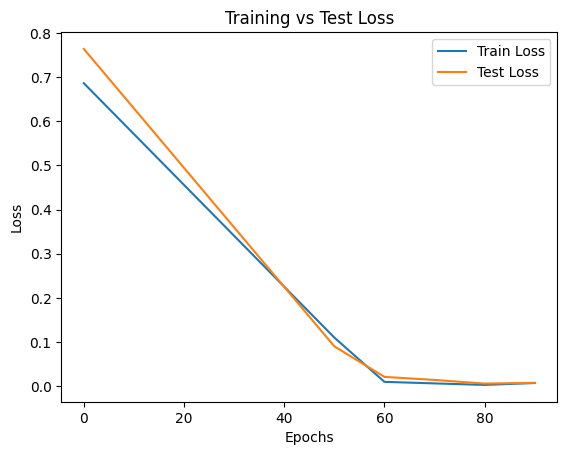

In [24]:
plt.plot(epoch_counts, np.array(torch.tensor(epoch_train_loss).cpu().numpy()), label="Train Loss")
plt.plot(epoch_counts, np.array(torch.tensor(epoch_test_loss).cpu().numpy()), label="Test Loss")
plt.title("Training vs Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [25]:
print(model_0.state_dict())

OrderedDict({'weight': tensor([0.6977]), 'bias': tensor([0.3080])})


In [26]:
with torch.inference_mode():
  final_preds = model_0(X_test)
# final_preds

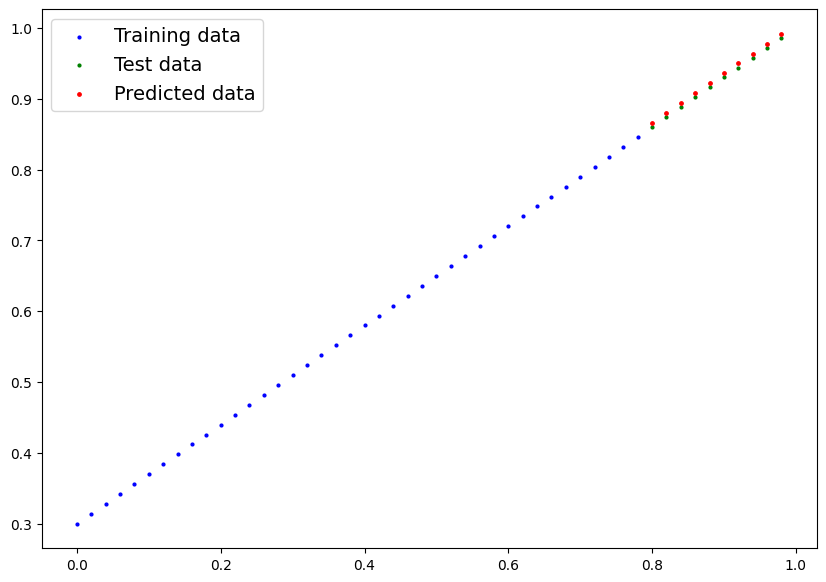

In [27]:
plot_parameters(predictions=final_preds)

In [28]:
# save and load the model
model_0.state_dict()

OrderedDict([('weight', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [29]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "001_LinearRegressionModel_01.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('models/001_LinearRegressionModel_01.pth')

In [30]:
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

In [31]:
model_1 = LinearRegressionModel()
model_1

LinearRegressionModel()

In [32]:
model_1.state_dict()

OrderedDict([('weight', tensor([0.3829])), ('bias', tensor([0.9593]))])

In [33]:
model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [34]:
model_1.state_dict()

OrderedDict([('weight', tensor([0.6977])), ('bias', tensor([0.3080]))])

In [35]:
model_1.eval()
with torch.inference_mode():
  y_pred = model_1(X_test)
(final_preds==y_pred).squeeze()

tensor([True, True, True, True, True, True, True, True, True, True])

In [36]:
next(model_1.parameters()).device

device(type='cpu')

In [106]:
torch.manual_seed(69)
class LinearRegressionModel_V1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=1, out_features=1)

  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.layer1(x)

In [107]:
model_2 = LinearRegressionModel_V1()
model_2.state_dict()

OrderedDict([('layer1.weight', tensor([[0.6796]])),
             ('layer1.bias', tensor([0.6083]))])

In [108]:
model_2.to(device)

LinearRegressionModel_V1(
  (layer1): Linear(in_features=1, out_features=1, bias=True)
)

In [109]:
train_model(model_2, X_train, y_train, 1000, X_test, y_test)

Iteration 0: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 10: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 20: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 30: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 40: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 50: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 60: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 70: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 80: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 90: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 100: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Iteration 110: Test Loss = 0.29011955857276917, Training_loss = 0.30033358931541443
Ite

In [110]:
model_2.eval()
with torch.inference_mode():
  model2_pred = model_2(X_test)
model2_pred

tensor([[1.1520],
        [1.1655],
        [1.1791],
        [1.1927],
        [1.2063],
        [1.2199],
        [1.2335],
        [1.2471],
        [1.2607],
        [1.2743]])

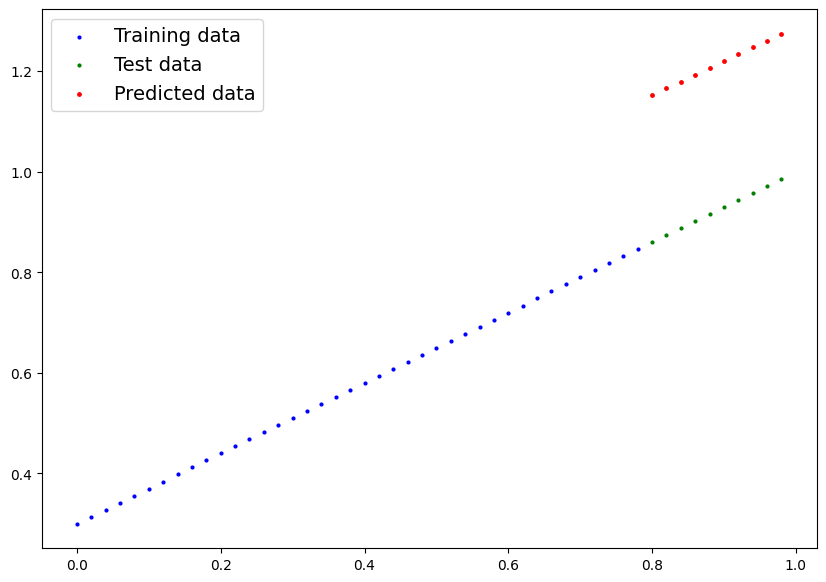

In [111]:
plot_parameters(predictions=model2_pred)